**Table of contents**<a id='toc0_'></a>    
- 1. [Preface](#toc1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Preface [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/work/py_modules/my_modules')
    workdir = '/Users/gaspard/work/'
from geostuff import transect

In [2]:
# Define functions
def b_positive(t, m, dmc):
    # find where M_ii < M_jj + dMc and t_ii < t_jj
    dt_mat = (t[np.newaxis, :] - t[:, np.newaxis]) / np.timedelta64(1, 'ms')  # ii > jj gives positive dt
    dm_mat = m[np.newaxis, :] - m[:, np.newaxis]

    pos_ii, pos_jj = np.where((dt_mat > 0.) & (dm_mat > dmc))

    # find the first event jj that satisfies the condition for each event ii
    dm_positive = []
    prev_ii = -1
    for id, ii in enumerate(pos_ii):
        if ii != prev_ii:
            dm_positive.append(dm_mat[ii, pos_jj[id]])
            prev_ii = ii

    dm_positive = np.array(dm_positive)
    b = 1/np.log(10) / (dm_positive - dmc).mean()
    return b, dm_positive

In [3]:
# Load JMA catalog
path = workdir + 'projects/data/Catalogs/JMA/jma_hypo_2000_2021.dat'

# Read catalog
cshift = 1  # use 1-indexing to better read the column using the guide at https://www.data.jma.go.jp/svd/eqev/data/bulletin/data/format/hypfmt_e.html

record_type_id = []
year = []
month = []
day = []
hour = []
minute = []
second = []
std_err_t = []
lat_deg = []
lat_min = []
std_err_lat = []
lon_deg = []
lon_min = []
std_err_lon = []
depth = []
std_err_depth = []
mag1 = []
mag1_type = []
mag2 = []
mag2_type = []
trav_t_table = []
hypo_loc_prec = []
sub_info = []
max_int = []
dam_class = []
tsun_class = []
distr_nb = []
reg_nb = []
reg_name = []
nb_st = []
hyp_det_flag = []


with open(path, 'r') as f:
    lines = f.readlines()
    for l in lines:
        # Read the line
        record_type_id.append(l[1 - cshift])
        year.append(l[2 - cshift:6 - cshift])
        month.append(l[6 - cshift:8 - cshift])
        day.append(l[8 - cshift:10 - cshift])
        hour.append(l[10 - cshift:12 - cshift])
        minute.append(l[12 - cshift:14 - cshift])
        second.append(l[14 - cshift:18 - cshift])
        std_err_t.append(l[18 - cshift:22 - cshift])
        lat_deg.append(l[22 - cshift:25 - cshift])
        lat_min.append(l[25 - cshift:29 - cshift])
        std_err_lat.append(l[29 - cshift:33 - cshift])
        lon_deg.append(l[33 - cshift:37 - cshift])
        lon_min.append(l[37 - cshift:41 - cshift])
        std_err_lon.append(l[41 - cshift:45 - cshift])
        depth.append(l[45 - cshift:50 - cshift])
        std_err_depth.append(l[50 - cshift:53 - cshift])
        mag1.append(l[53 - cshift:55 - cshift])
        mag1_type.append(l[55 - cshift])
        mag2.append(l[56 - cshift:58 - cshift])
        mag2_type.append(l[58 - cshift])
        trav_t_table.append(l[59 - cshift])
        hypo_loc_prec.append(l[60 - cshift])
        sub_info.append(l[61 - cshift])
        max_int.append(l[62 - cshift])
        dam_class.append(l[63 - cshift])
        tsun_class.append(l[64 - cshift])
        distr_nb.append(l[65 - cshift])
        reg_nb.append(l[66 - cshift:69 - cshift])
        reg_name.append(l[69 - cshift:93 - cshift])
        nb_st.append(l[93 - cshift:96 - cshift])
        hyp_det_flag.append(l[96 - cshift])

In [4]:
# Process the columns
# --> Time 
year = np.array(year, dtype=int)
month = np.array(month, dtype=int)
day = np.array(day, dtype=int)
hour = np.array(hour, dtype=int)
minute = np.array(minute, dtype=int)
second = np.array(second, dtype=float)/100
std_err_t = np.array([float(err) if err != '    ' else 0. for err in std_err_t]) / 100

date = [np.datetime64(f'{y:04d}-{m:02d}-{d:02d}T{h:02d}:{mi:02d}:{s:05.2f}') for y, m, d, h, mi, s in zip(year, month, day, hour, minute, second)]

# --> Location
lat_deg = np.array([float(l.replace(" ", "")) for l in lat_deg])
lat_min = np.array(lat_min, dtype=float)/100
std_err_lat = np.array([float(err) if err != '    ' else 0. for err in std_err_lat]) / 100 / 60

lat = lat_deg + lat_min/60

lon_deg = np.array([float(l.replace(" ", "")) for l in lon_deg])
lon_min = np.array(lon_min, dtype=float)/100
lon = lon_deg + lon_min/60
std_err_lon = np.array([float(err) if err != '    ' else 0. for err in std_err_lon]) / 100 / 60

depth = np.array([float(d.replace(" ", "0")) / 100 if d[-2] != '  ' else float(d) for d in depth])
std_err_depth = np.array([float(err) if err != '   ' else 0. for err in std_err_depth]) / 100

# --> Magnitude
for ii, m in enumerate(mag1):
    if m == '  ':
        mag1[ii] = np.nan
    elif m[0] == '-':
        mag1[ii] = -float(m[1])/10
    elif m[0] == 'A':
        mag1[ii] = -1. - float(m[1])/10
    elif m == 'B':
        mag1[ii] = -2 - float(m[1])/10
    elif m == 'C':
        mag1[ii] = -3 - float(m[1])/10
    else:
        mag1[ii] = float(m) / 10
mag1 = np.array(mag1)

for ii, m in enumerate(mag2):
    if m == '  ':
        mag2[ii] = np.nan
    elif m[0] == '-':
        mag2[ii] = -float(m[1])/10
    elif m[0] == 'A':
        mag2[ii] = -1. - float(m[1])/10
    elif m == 'B':
        mag2[ii] = -2 - float(m[1])/10
    elif m == 'C':
        mag2[ii] = -3 - float(m[1])/10
    else:
        mag2[ii] = float(m) / 10
mag2 = np.array(mag2)

# --> Event types
for ii, info in enumerate(sub_info):
    if info == '1':
        sub_info[ii] = 'eq'
    elif info == '2':
        sub_info[ii] = 'too few jma st'
    elif info == '3':
        sub_info[ii] = 'artificial event'
    elif info == '4':
        sub_info[ii] = 'eruption eq and others'
    elif info == '5':
        sub_info[ii] = 'lfe'
sub_info = np.array(sub_info)

# --> Location
distr_nb = np.array([int(d) for d in distr_nb])
reg_nb = np.array([int(r) if r != '   ' else 0 for r in reg_nb])
nb_st = np.array([int(n) if n != '   ' else 0 for n in nb_st])

In [5]:
# Make a dataframe out of the columns
jma = pd.DataFrame({'date': date, 'lat': lat, 'lon': lon, 'depth': depth, 'mag1': mag1, 'mag2': mag2, 'sub_info': sub_info, 'distr_nb': distr_nb, 'reg_nb': reg_nb, 'nb_st': nb_st})
eq = jma[jma.sub_info == 'eq']
lfe = jma[jma.sub_info == 'lfe']

# Save the catalogs
eq.to_csv(workdir + 'projects/data/Catalogs/JMA/eq_2000_2021.csv', index=False)
lfe.to_csv(workdir + 'projects/data/Catalogs/JMA/lfe_2000_2021.csv', index=False)
jma.to_csv(workdir + 'projects/data/Catalogs/JMA/jma_2000_2021.csv', index=False)

# Delete columns and lines 
del date, lat, lat_deg, lat_min, lon, lon_deg, lon_min, depth, mag1, mag2, sub_info, distr_nb, reg_nb, nb_st, year, month, day, hour, minute, second, std_err_t, std_err_lat, std_err_lon, std_err_depth, mag1_type, mag2_type, trav_t_table, hypo_loc_prec, max_int, dam_class, tsun_class, reg_name, hyp_det_flag

# Overview

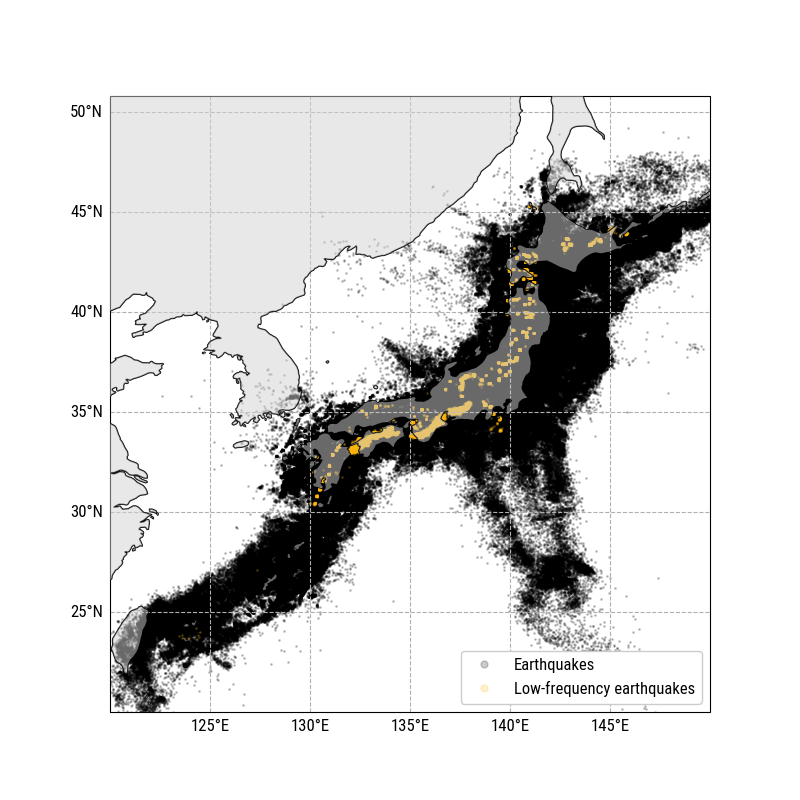

In [6]:
# Map the catalog
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, zorder=10)
ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

ax.plot(eq.lon, eq.lat, 'o', color=to_rgba('k', .2), markersize=1, transform=ccrs.PlateCarree(), label='Earthquakes')
ax.plot(lfe.lon, lfe.lat, 'o', color=to_rgba('C2', .2), markersize=1, transform=ccrs.PlateCarree(), label='Low-frequency earthquakes')


# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

ax.legend(framealpha=1, loc='lower right', markerscale=5)

ax.set_extent([120, 150, 20, 50])

plt.show()

# Zoom in Nankai/Tonankai/Tokai

16

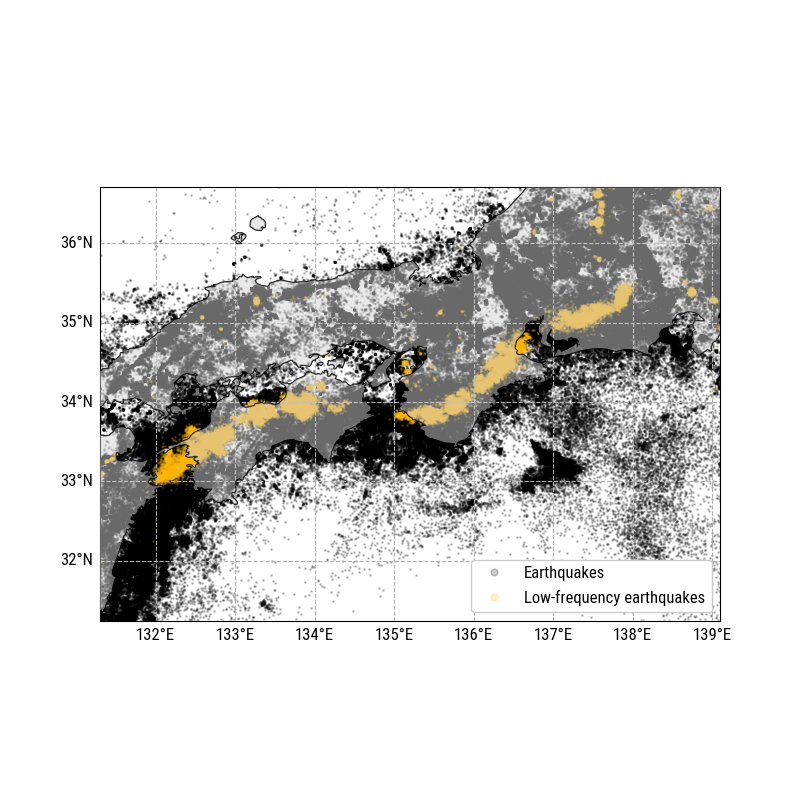

Point picked: Latitude=32.679193548386976, Longitude=131.75290322580597
Point picked: Latitude=35.83693548387082, Longitude=138.20677419354786


In [10]:
# Map the catalog and pick transect points
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, zorder=10)
ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

ax.plot(eq.lon, eq.lat, 'o', color=to_rgba('k', .2), markersize=1, transform=ccrs.PlateCarree(), label='Earthquakes')
ax.plot(lfe.lon, lfe.lat, 'o', color=to_rgba('C2', .2), markersize=1, transform=ccrs.PlateCarree(), label='Low-frequency earthquakes')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

ax.legend(framealpha=1, loc='lower right', markerscale=5)

ax.set_extent([131.3, 139.1, 31.25, 36.7])

picked_locations = []
# Define the on_click event handler function
def on_click(event):
    if event.inaxes == ax:
        # Get the latitude and longitude of the clicked point
        lon, lat = event.xdata, event.ydata
        picked_locations.append((lon, lat))
        print(f"Point picked: Latitude={lat}, Longitude={lon}")
        ax.plot([pl[0] for pl in picked_locations], [pl[1] for pl in picked_locations], 'x-', color='r', markersize=10, zorder=11, transform=ccrs.PlateCarree())
        plt.draw()

# Connect the on_click event handler to the figure
fig.canvas.mpl_connect('button_press_event', on_click)

In [11]:
# Terminate the interactive mode
plt.close()

In [12]:
# Project earthquakes and lfes on the transect
transect_points = dict(W=dict(longitude=picked_locations[0][0], latitude=picked_locations[0][1]),
                E=dict(longitude=picked_locations[1][0], latitude=picked_locations[1][1]))

# Earthquakes
t = transect(eq.lon.values, eq.lat.values, transect_points['W']['longitude'], transect_points['W']['latitude'], transect_points['E']['longitude'], transect_points['E']['latitude'])
eq['xf'] = t[0]
eq['yf'] = t[1]

# LFEs
t = transect(lfe.lon.values, lfe.lat.values, transect_points['W']['longitude'], transect_points['W']['latitude'], transect_points['E']['longitude'], transect_points['E']['latitude'])
lfe['xf'] = t[0]
lfe['yf'] = t[1]

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_11388/2227463754.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq['xf'] = t[0]
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_11388/2227463754.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq['yf'] = t[1]
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_11388/2227463754.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

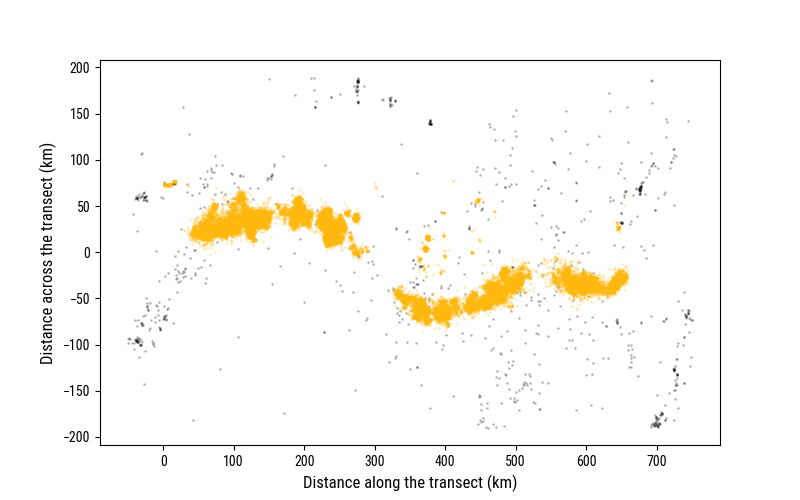

In [17]:
# Select earthquakes and LFEs
min_xf_eq = -50.  # in km 
max_xf_eq = 750.
min_yf_eq = -190.
max_yf_eq = 190.
eq_indicator = (eq.xf > min_xf_eq) & (eq.xf < max_xf_eq) & (eq.yf > min_yf_eq) & (eq.yf < max_yf_eq)

mag_min = 4.

eq_in_box = eq[eq_indicator & (eq.mag1 >= mag_min)]

min_xf_lfe = 0.
max_xf_lfe = 660.
min_yf_lfe = -100.
max_yf_lfe = 80.
lfe_indicator = (lfe.xf > min_xf_lfe) & (lfe.xf < max_xf_lfe) & (lfe.yf > min_yf_lfe) & (lfe.yf < max_yf_lfe)
lfe_in_box = lfe[lfe_indicator]

# Plot the selected earthquakes and LFEs
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel('Distance along the transect (km)')
ax.set_ylabel('Distance across the transect (km)')

ax.plot(eq_in_box.xf, eq_in_box.yf, 'o', color=to_rgba('k', .2), markersize=1, label='Earthquakes')
ax.plot(lfe_in_box.xf, lfe_in_box.yf, 'o', color=to_rgba('C2', .2), markersize=1, label='Low-frequency earthquakes')

plt.show()


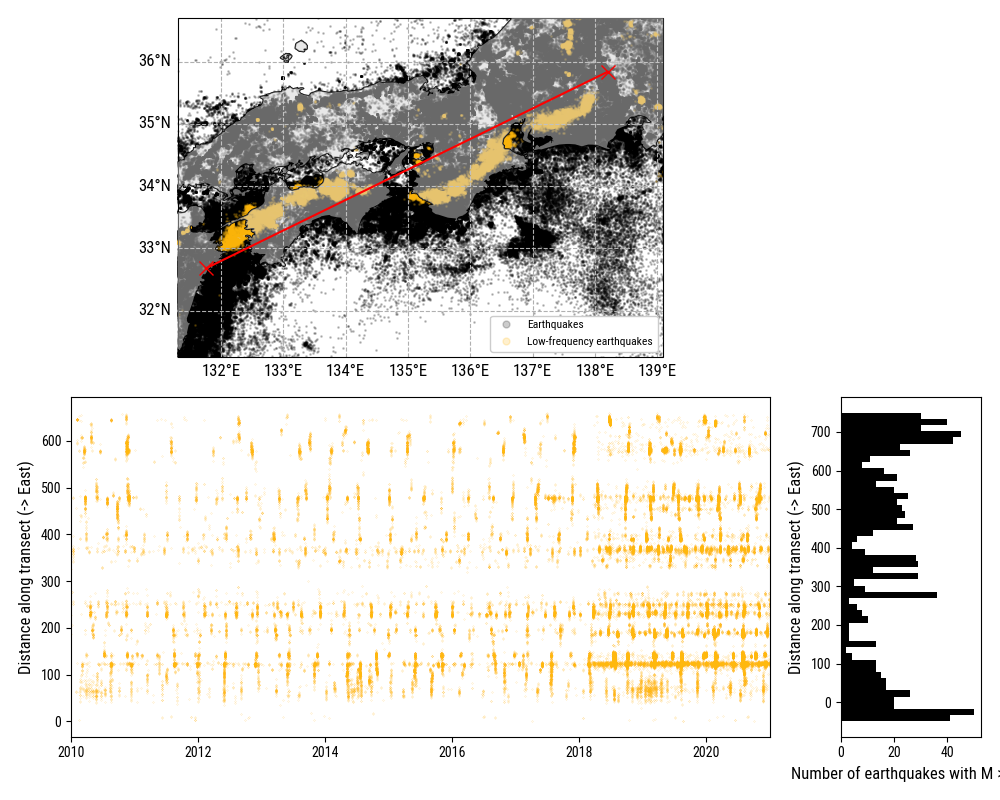

In [28]:
# Show activity in space and time
# Compare to tremor
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[5, 1])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, zorder=10)
ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

ax.plot(eq.lon, eq.lat, 'o', color=to_rgba('k', .2), markersize=1, transform=ccrs.PlateCarree(), label='Earthquakes')
ax.plot(lfe.lon, lfe.lat, 'o', color=to_rgba('C2', .2), markersize=1, transform=ccrs.PlateCarree(), label='Low-frequency earthquakes')

ax.plot([transect_points['W']['longitude'], transect_points['E']['longitude']], [transect_points['W']['latitude'], transect_points['E']['latitude']], 'x-', color='r', markersize=10, transform=ccrs.PlateCarree(), zorder=10)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

ax.legend(framealpha=1, loc='lower right', markerscale=5, fontsize='x-small')

ax.set_extent([131.3, 139.1, 31.25, 36.7])

# Plot the LFE activity in space and time
ax = fig.add_subplot(gs[1, 0])
ax.set_ylabel('Distance along transect (-> East)')
ax.plot(lfe_in_box.date, lfe_in_box.xf, 'o', ms=.1, color=to_rgba('C2', 1), label='LFEs')

ax.set_xlim(np.datetime64('2010-01-01'), np.datetime64('2021-01-01'))

# Plot the EQ activity
ax = fig.add_subplot(gs[1, 1])
ax.set_ylabel('Distance along transect (-> East)')
ax.set_xlabel(f'Number of earthquakes with M > {mag_min}')

ax.hist(eq_in_box.xf, bins=50, color=to_rgba('k', 1), orientation='horizontal')

plt.tight_layout()
plt.show()
